데이터를 가져오는 중입니다... (20210214 ~ 20260213)


[*********************100%***********************]  1 of 1 completed


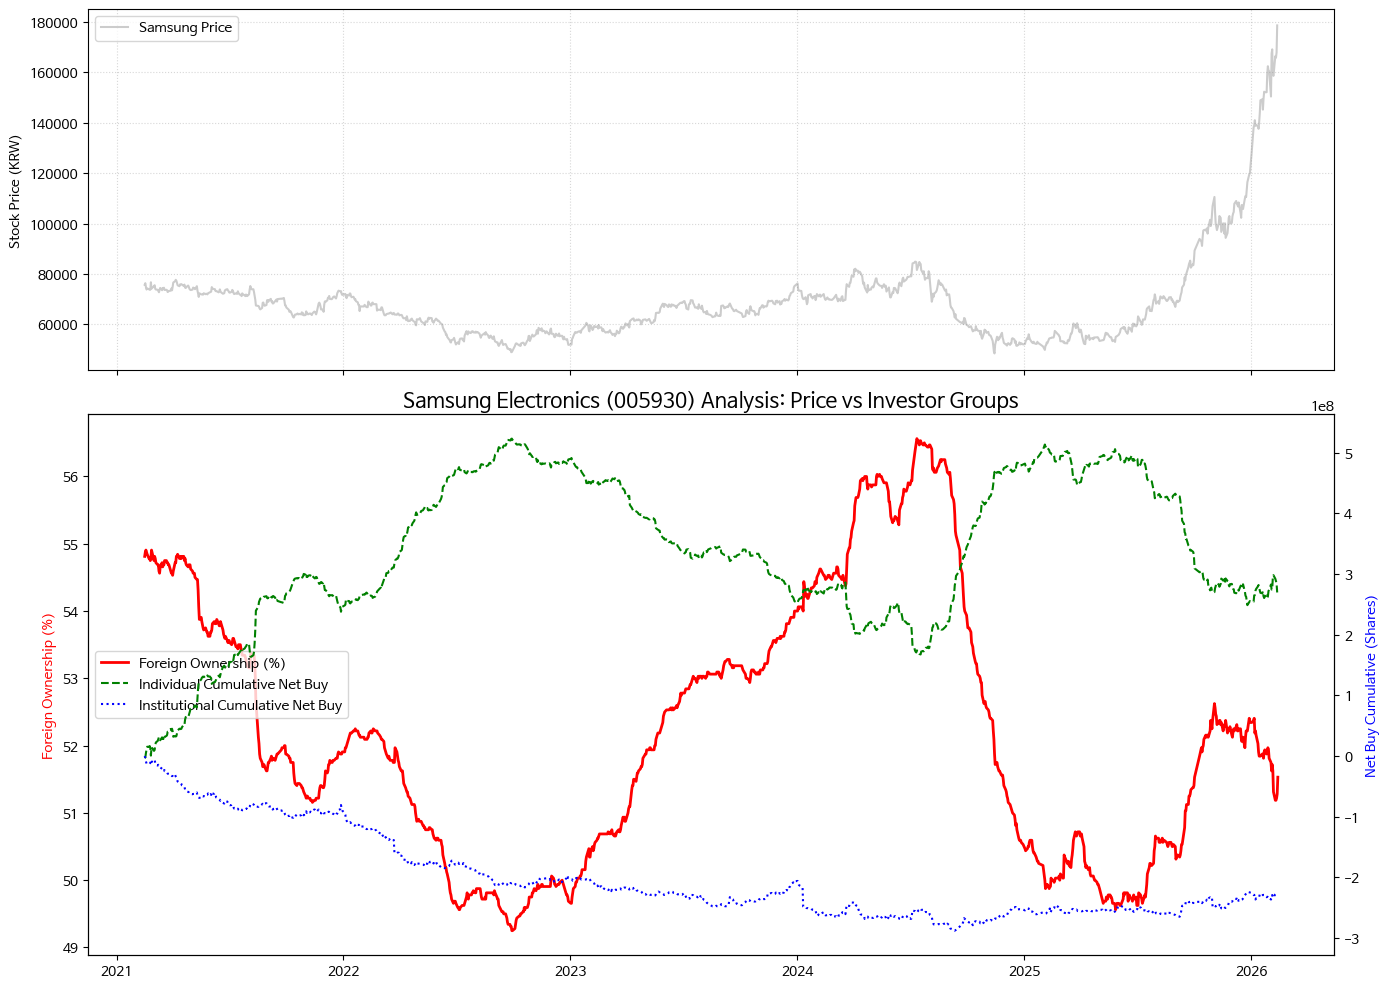

In [1]:
import yfinance as yf
from pykrx import stock
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# 1. 설정: 삼성전자(005930), 최근 5년 데이터
symbol = "005930"
end_date = datetime.date.today().strftime("%Y%m%d")
start_date = (datetime.date.today() - datetime.timedelta(days=365 * 5)).strftime("%Y%m%d")

print(f"데이터를 가져오는 중입니다... ({start_date} ~ {end_date})")

# 2. 투자자별 보유 수량 데이터 가져오기 (KRX)
# 일자별로 외국인, 기관, 개인이 보유한 '순보유수량'을 가져옵니다.
df_investor = stock.get_market_net_purchases_of_equities_by_ticker(start_date, end_date, symbol)
# 보유 현황을 알기 위해 일자별 '보유수량' 데이터를 가져옵니다.
df_holdings = stock.get_exhaustion_rates_of_foreign_investment_by_date(start_date, end_date, symbol)

# 3. 주가 데이터 가져오기 (yfinance)
df_price = yf.download(f"{symbol}.KS", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)

# 4. 데이터 정리: 지분율 계산
# KRX에서 제공하는 외국인 보유비율을 사용하고, 기관/개인은 전체 주식수 대비 비율로 계산합니다.
total_shares = 5969782550  # 삼성전자 보통주 총 발행 주식 수 (고정값 활용 가능)

# 외국인 지분율은 df_holdings의 '지분율' 컬럼 활용
foreign_pct = df_holdings['지분율']

# 기관 및 개인은 누적 순매수량을 기반으로 비중 변화를 추산 (단순화 모델)
# 실제 정확한 지분율은 매 분기 공시를 봐야 하지만, 추세 확인을 위해 수급 데이터를 활용합니다.
investor_trade = stock.get_market_trading_volume_by_date(start_date, end_date, symbol)
inst_cumsum = investor_trade['기관합계'].cumsum()
indiv_cumsum = investor_trade['개인'].cumsum()

# 5. 그래프 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

# 상단: 주가 차트
ax1.plot(df_price.index, df_price['Close'], color='gray', alpha=0.4, label='Samsung Price')
ax1.set_ylabel('Stock Price (KRW)')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.5)

# 하단: 지분율/수급 추이 차트
# 외국인 지분율 (실제 비율 데이터)
ax2.plot(foreign_pct.index, foreign_pct, color='red', linewidth=2, label='Foreign Ownership (%)')

# 기관/개인은 상대적 변화를 보기 위해 우측 축(Secondary Y) 또는 변환하여 표시
ax3 = ax2.twinx()
ax3.plot(indiv_cumsum.index, indiv_cumsum, color='green', linewidth=1.5, linestyle='--', label='Individual Cumulative Net Buy')
ax3.plot(inst_cumsum.index, inst_cumsum, color='blue', linewidth=1.5, linestyle=':', label='Institutional Cumulative Net Buy')

# 라벨 및 타이틀
ax2.set_ylabel('Foreign Ownership (%)', color='red')
ax3.set_ylabel('Net Buy Cumulative (Shares)', color='blue')
plt.title(f"Samsung Electronics ({symbol}) Analysis: Price vs Investor Groups", fontsize=15)

# 범례 통합
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center left')

plt.tight_layout()
plt.show()

데이터를 수집 중입니다... (에러 수정 버전)


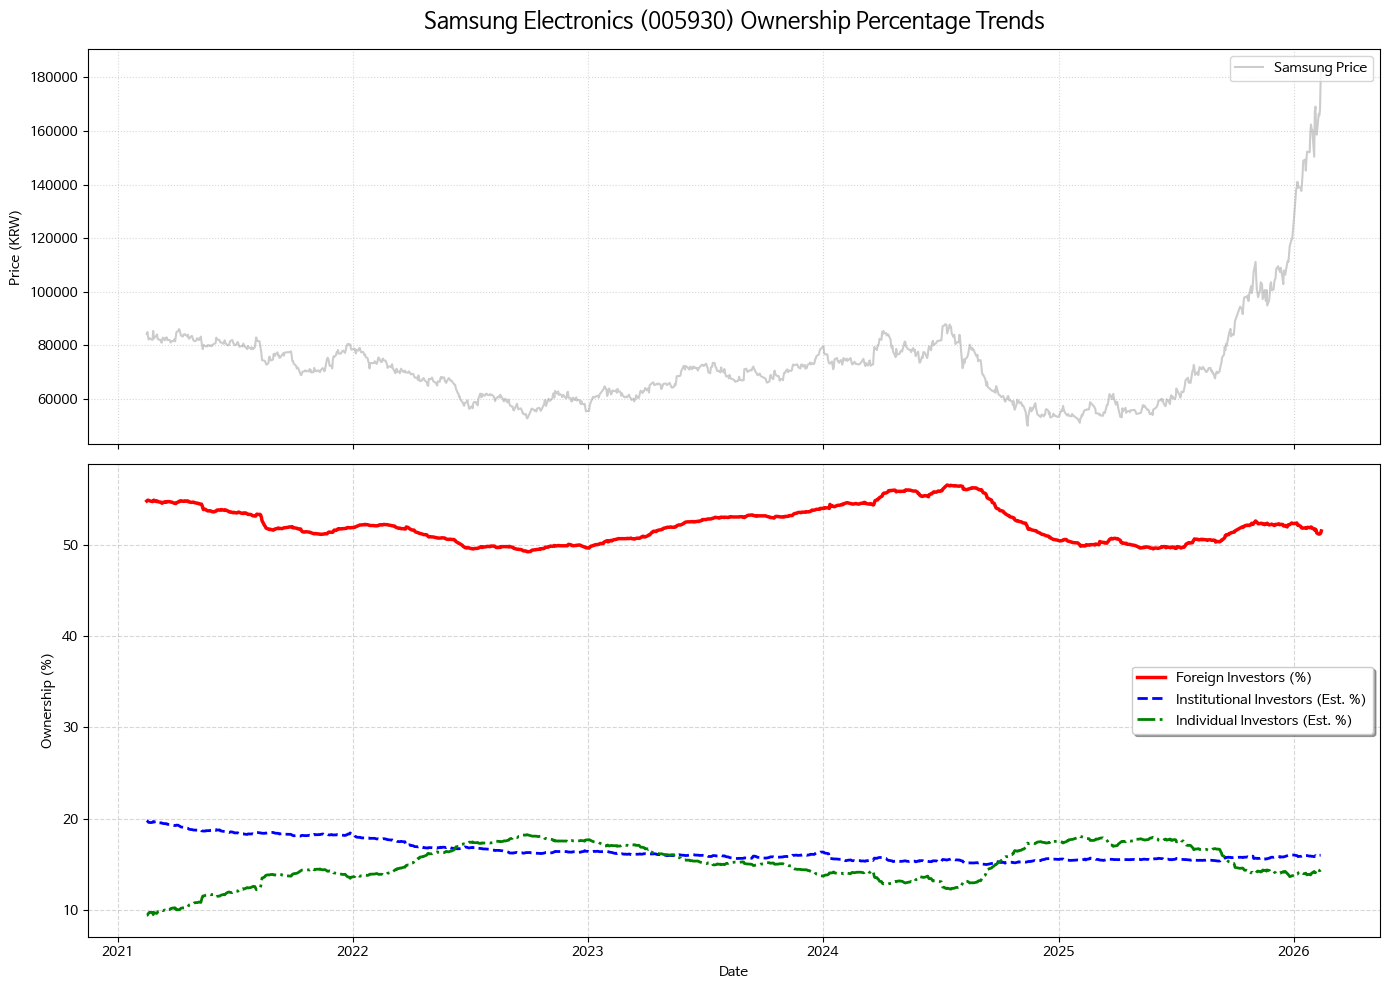

: 

In [ ]:
import yfinance as yf
from pykrx import stock
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# 1. 설정
symbol = "005930"  # 삼성전자
end_date = datetime.date.today().strftime("%Y%m%d")
start_date = (datetime.date.today() - datetime.timedelta(days=365 * 5)).strftime("%Y%m%d")

print(f"데이터를 수집 중입니다... (에러 수정 버전)")

# 2. 기초 데이터 수집
# 발행주식수 (삼성전자 보통주 기준)
total_shares = 5969782550 

# 투자자별 순매수량 (get_market_net_purchase_of_equities_by_ticker 대신 안전한 함수 사용)
# '일자별' 순매수량을 가져오기 위해 get_market_trading_volume_by_date를 사용합니다.
df_investor = stock.get_market_trading_volume_by_date(start_date, end_date, symbol)

# 외국인 공식 지분율 데이터
df_foreign = stock.get_exhaustion_rates_of_foreign_investment_by_date(start_date, end_date, symbol)

# 주가 데이터 (OHLCV)
df_price = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)

# 3. 지분율(%) 계산
# 외국인 지분율은 제공되는 데이터를 그대로 사용
foreign_pct = df_foreign['지분율']

# 기관과 개인은 현재 시점의 대략적인 지분율 기준값에서 순매수 변동분(%)을 누적하여 추계
# 삼성전자 2024년 말 기준 대략적 비중: 개인(약 13~15%), 기관(약 16~18%)
inst_base = 16.0 
indiv_base = 14.0

# (순매수량 / 총발행주식수) * 100 = 지분율 변동폭(%)
inst_delta = (df_investor['기관합계'] / total_shares) * 100
indiv_delta = (df_investor['개인'] / total_shares) * 100

# 현재를 기준으로 과거 데이터를 역산하여 추이 생성
inst_pct = inst_base + (inst_delta.cumsum() - inst_delta.cumsum().iloc[-1])
indiv_pct = indiv_base + (indiv_delta.cumsum() - indiv_delta.cumsum().iloc[-1])

# 4. 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1.2]})

# 상단: 주가
ax1.plot(df_price.index, df_price['종가'], color='gray', alpha=0.4, label='Samsung Price')
ax1.set_ylabel('Price (KRW)')
ax1.set_title(f'Samsung Electronics ({symbol}) Ownership Percentage Trends', fontsize=16, pad=15)
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.5)

# 하단: 모든 주체 지분율(%) 선 그래프
ax2.plot(foreign_pct.index, foreign_pct, color='red', linewidth=2.5, label='Foreign Investors (%)')
ax2.plot(inst_pct.index, inst_pct, color='blue', linewidth=2, linestyle='--', label='Institutional Investors (Est. %)')
ax2.plot(indiv_pct.index, indiv_pct, color='green', linewidth=2, linestyle='-.', label='Individual Investors (Est. %)')

ax2.set_ylabel('Ownership (%)')
ax2.set_xlabel('Date')
ax2.legend(loc='center right', frameon=True, shadow=True)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()